In [1]:
import datasets
import debug_helpers
import persistence
import plots
import convergence_criterion as cc
import initializations as inits
import IBM2 as ibm2


# pretty print variabeles on line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
s_t_pairs, _, _ = datasets.example_data_word_order()

lprobs_random = inits.initialize_lprobs_randomly(s_t_pairs)
jump_probs_random = inits.initialize_jump_probs_randomly(s_t_pairs)

(lprobs, jump_probs, _, _) = ibm2.EM(
    s_t_pairs, 
    lprobs_random, 
    jump_probs_random, 
    30
) 

s_t_pairs
debug_helpers.print_lexicon_probs(None, lprobs, None, None)
jump_probs



[(['<NULL>', 'Haus', 'das'], ['the', 'house']),
 (['<NULL>', 'Buch', 'das'], ['the', 'book']),
 (['<NULL>', 'Buch', 'ein'], ['a', 'book']),
 (['<NULL>', 'Maus', 'ein'], ['a', 'mouse']),
 (['<NULL>', 'Hund', 'das'], ['the', 'dog']),
 (['<NULL>', 'Welt', 'ein'], ['a', 'world']),
 (['<NULL>', 'Boot', 'das'], ['the', 'boat']),
 (['<NULL>', 'Brugge', 'ein'], ['a', 'bridge'])]

<NULL> the 0.0004847114832307746
<NULL> house 6.835033597995697e-10
<NULL> book 0.9993478334157265
<NULL> a 0.00016745006634285642
<NULL> mouse 1.2739011403125033e-09
<NULL> dog 8.333672550220575e-10
<NULL> world 1.8463507508979209e-09
<NULL> boat 3.214375330641175e-10
<NULL> bridge 7.61395716209271e-11
Haus the 1.0
das house 0.2500000000356462
das book 0.24999999989306143
das dog 0.2500000000356462
das boat 0.2500000000356462
Buch the 0.4999999999999638
Buch a 0.5000000000000362
ein book 0.24999999989306143
ein mouse 0.2500000000356462
ein world 0.2500000000356462
ein bridge 0.2500000000356462
Maus a 1.0
Hund the 1.0
Welt a 1.0
Boot the 1.0
Brugge a 1.0



[0.0, 0.9999999999286611, 0.0, 7.133890905249892e-11]

In [3]:
def fname_ibm2(fname):
    return f'IBM2_output/{fname}'

# HACK: store converged models during the iteration run
converged_models = []
def save_selected_models(i, llhood, AER, prev_llhood, prev_AER,
                      lprobs, jump_probs, mname):
    debug_helpers.print_likelihood(i, [], llhood, AER)
    if prev_AER and (f'{mname}_AER' not in converged_models) and cc.has_converged_AER(prev_AER, AER):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_AER_{i}.txt'))
        converged_models.append(f'{mname}_AER')
    if prev_llhood and (f'{mname}_LL' not in converged_models) and cc.has_converged_LLhood(prev_llhood, llhood):
        persistence.save_ibm2_model(lprobs, jump_probs, fname_ibm2(f'params_{mname}_llhood_{i}.txt'))
        converged_models.append(f'{mname}_LL')
        
def run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    fn_init, fn_init_jumps, init_name):

    lprobs_init = fn_init(s_t_pairs)
    jump_probs_init = fn_init_jumps(s_t_pairs)

    # EM
    (lprobs, jump_probs, llhoods, AERs) = ibm2.EM (
        s_t_pairs, 
        lprobs_init, 
        jump_probs_init,
        15,
        val_sentence_pairs, reference_alignments, 
        save_selected_models, init_name)

    # store AER and llhood scores in file
    persistence.save(AERs, fname_ibm2(f'AERs_{init_name}.txt'))
    persistence.save(llhoods, fname_ibm2(f'llhoods_{init_name}.txt'))

    # select models based on AER and llhood selection criterion
    selected_model_AER = fname_ibm2(cc.select_model_AER(AERs))
    selected_model_llhood = fname_ibm2(cc.select_model_LLhood(llhoods))
    print(f'model selected on AER for {init_name}:', selected_model_AER)
    print(f'model selected on LLhood for {init_name}:', selected_model_llhood)

    # plot AER and llhood scores vs iteration
#    plots.figure_log_likelihood(llhoods, fname_ibm2(f'IBM2_{init_name}'))
#    plots.figure_AER(AERs, fname_ibm2(f'IBM2_{init_name}'))

In [6]:
# s_t_pairs, s_vocabulary, t_vocabulary = datasets.training_data()
# val_sentence_pairs = datasets.validation_data(s_vocabulary, t_vocabulary)
# reference_alignments = datasets.validation_alignments()    

s_t_pairs, s_vocabulary, t_vocabulary = datasets.example_data_word_order()
val_sentence_pairs = None
reference_alignments = None    

converged_models = []

# Run EM on training data set with AER on validation set
# using random initialization (3x)
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_1')
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_2')
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_randomly, inits.initialize_jump_probs_randomly, 'IBM2_RR_3')

# Run EM on training data set with AER on validation set
# using uniform initialization 
run_em_with_initialization(
    s_t_pairs, val_sentence_pairs, reference_alignments,
    inits.initialize_lprobs_uniform, inits.initialize_jump_probs_uniformly, 'IBM2_uniform')

# Run EM on training data set with AER on validation set
# using initialization with IBM 1 und uniform jump probabilities
# run_em_with_initialization(
#     s_t_pairs, val_sentence_pairs, reference_alignments,
#     inits.initialize_lprobs_staged, inits.initialize_jump_probs_uniformly, 'IBM2_staged')





iteration    log_likelihood    AER    time
0 -21.522 0.00000 11:54
1 -18.147 0.00000 11:54
2 -16.497 0.00000 11:54
3 -15.491 0.00000 11:54
4 -14.413 0.00000 11:54
5 -13.249 0.00000 11:54
6 -12.598 0.00000 11:54
7 -12.489 0.00000 11:54
8 -12.480 0.00000 11:54
9 -12.478 0.00000 11:54
10 -12.477 0.00000 11:54
11 -12.477 0.00000 11:54
12 -12.477 0.00000 11:54
13 -12.477 0.00000 11:54
14 -12.477 0.00000 11:54
model selected on AER for IBM2_RR_1: IBM2_output/None
model selected on LLhood for IBM2_RR_1: IBM2_output/8
iteration    log_likelihood    AER    time
0 -19.878 0.00000 11:54
1 -12.149 0.00000 11:54
2 -6.219 0.00000 11:54
3 -1.832 0.00000 11:54
4 -0.492 0.00000 11:54
5 -0.229 0.00000 11:54
6 -0.115 0.00000 11:54
7 -0.058 0.00000 11:54
8 -0.029 0.00000 11:54
9 -0.014 0.00000 11:54
10 -0.007 0.00000 11:54
11 -0.004 0.00000 11:54
12 -0.002 0.00000 11:54
13 -0.001 0.00000 11:54
14 -0.000 0.00000 11:54
model selected on AER for IBM2_RR_2: IBM2_output/None
model selected on LLhood for IBM2_R

In [ ]:
converged_models


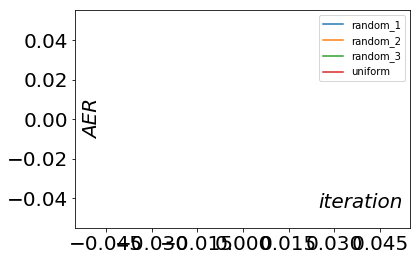

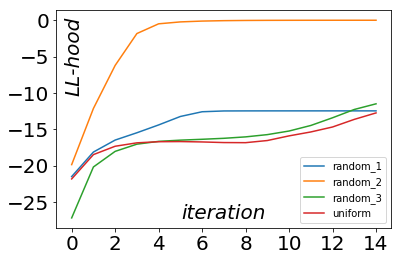

In [10]:
def add_plot_data(init_name, label):
    fname_ibm2_AERs = fname_ibm2(f'AERs_{init_name}.txt')    
    fname_ibm2_llhoods = fname_ibm2(f'llhoods_{init_name}.txt')
    AERs = persistence.load(fname_ibm2_AERs)
    llhoods = persistence.load(fname_ibm2_llhoods)
    AER_lines.append(AERs)
    llhood_lines.append(llhoods)
    model_names.append(label) 
    
AER_lines = []
llhood_lines = []
model_names = []
for i in [1,2,3]:
    init_name = f'IBM2_RR_{i}'
    add_plot_data(init_name, f'random_{i}')
add_plot_data('IBM2_uniform', 'uniform')
#add_plot_data('IBM2_staged')

plots.figure_AER_multiple_lines(AER_lines, model_names, fname_ibm2('IBM2_inits_AER.png'))
plots.figure_llhood_multiple_lines(llhood_lines, model_names, fname_ibm2('IBM2_inits_llhoods.png'))